In [1]:
# From Deep Reinforcement Learning  in Action Ch2 V2 of the code
## from multi-armed Bandits to contextual bandits
### Chapter 2
#modified with comments jw april 25,2019 - azure ml meetup
#contextual bandit is a variation of multi-armed bandit. the contextual refers to the current state
#of the simulation which is used as input to the deep neural net model to predict the reward. 
#that predicted reward is then comapared against the calculated reward, representing the loss function,
#which is what our DNN tries to minimize.
#try to use more intuitive naming
#site refers to one of 10 possible web sites to be visiting
#ads refers to one of 10 ads to show given a site that is currently being visited
#there is a random probability of someone clicking on an ad they see on that site
#the agent tries to find a strategy that optimizes rewards where rewards are based on the probability of clikcing on a ad
#this is a simulation of the above with some simple assumptions.

In [2]:
import numpy as np
import torch as th
from torch.autograd import Variable
from matplotlib import pyplot as plt
import random
%matplotlib inline

This defines the main contextual bandit class we'll be using as our environment/simulator to train a neural network.

In [3]:
#ads here represent the choices (ads) to select from 
#sites represent the current part of the web site visited - renaming that to site
#goal is to have a matrix of row(site) by column(ad)
#step 1 - rename state to site - ok 4/22
#step 2 - rename ads to ads since that is the choice to be made (select the ad to show given at site 'x')
# and rename  to ad 
np.set_printoptions(precision=3) 

class ContextBandit:
    def __init__(self, ads=10):
        self.ads   = ads
        self.sites = ads                  #convenience - no need to have a 10 by 10 matrix
        self.init_distribution(ads)
        self.update_site()                #selects a site at random
        print('initial ads probs for a site ',self.site,' are  ', self.bandit_matrix[self.site])
        #print('initial site value is   ',self.site)
        #print('initial matrix is       ',self.bandit_matrix)
        
    def init_distribution(self, ads):
        # Num sites = Num ads to keep things simple
        self.bandit_matrix = np.random.rand(ads,ads)
        #each row represents a site, each column an ad
        
        #rewards are calculated based on probability with the probability coming from
        #the /site matrix location set up in the class initializer
        #note how reward is not static but probabilistic which is quite different than our multi-armed bandit model
    def reward(self, prob):
        reward = 0
        for i in range(self.ads):
            if random.random() < prob:
                reward += 1
        #print('Reward returned is ', reward, ' for prob ', prob)        
        return reward
        
    def get_site(self):
        return self.site
    
    def update_site(self):
        self.site = np.random.randint(0,self.sites)
        
    def get_reward(self,ad):
        return self.reward(self.bandit_matrix[self.get_site()][ad])
        
    def choose_ad(self,ad ):
        reward = self.get_reward(ad)
        self.update_site()
        return reward
    

Here we define our simple neural network model using PyTorch

In [7]:

#run a single simulation event               


In [8]:
def softmax(av, tau=1.12):
    n     = len(av)
    probs = np.zeros(n)
    for i in range(n):
        softm    = ( np.exp(av[i] / tau) / np.sum( np.exp(av[:] / tau) ) )
        probs[i] = softm
    return probs

def one_hot(N, pos, val=1):
    one_hot_vec      = np.zeros(N)
    one_hot_vec[pos] = val
    return one_hot_vec

ads   = 10 #also sets our site space to 10 - resulting in a 10 by 10 matrix of ads/sites
sites = 10
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 1, sites, 100, ads

model = th.nn.Sequential(
    th.nn.Linear(D_in, H),
    th.nn.ReLU(),
    th.nn.Linear(H, D_out),
    th.nn.ReLU(),
)
print("model type is ",model.type)

loss_fn = th.nn.MSELoss(size_average=False)
env=None
env = ContextBandit(ads)

model type is  <bound method Module.type of Sequential(
  (0): Linear(in_features=10, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=10, bias=True)
  (3): ReLU()
)>
initial ads probs for a site  6  are   [0.502 0.905 0.963 0.655 0.045 0.208 0.428 0.598 0.858 0.025]


C:\anaconda3\envs\tensorflow\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [24]:
#smoke test cell 
print('---smoke test of ContextBandit---')
np.set_printoptions(precision=3)
envtest     = ContextBandit(10)
testsite    = Variable(th.Tensor(one_hot(ads,env.get_site()))) 

tpredrew    = model(testsite)                        #produce reward predictions for current site
tav_softmax = softmax(tpredrew.data.numpy(), tau=2.0) #turn reward distribution into probability distribution
tsoft       = th.nn.functional.softmax(tpredrew,dim=0)
print('tsoftsum is ',tsoft.sum())
print('tsoft ',tsoft)
print('AVSOFTSUM',tav_softmax.sum())
tav_softmax /= tav_softmax.sum()
print('Normalized AVSOFTSUM ',tav_softmax)             #make sure total prob adds to 1 - replace with tsoft
ttsoft = tsoft.detach().numpy()                        #go from tensor to numpy which is what choice expects
print('ttsoft: ',ttsoft.sum())
#tchoice     = np.random.choice(ads, p=tav_softmax)    #randomly chhose an ad - notice p=av_softmax
tchoice     = np.random.choice(ads,p=ttsoft)           #should work the same and removes unneeded steps
print('tchoice ', tchoice)
tcur_reward = env.choose_ad(tchoice)                   #smoke test of the ContextBandit
print('test rewards ',tcur_reward)
                                                         #value function calcs the ad chosen above 
tone_hot_reward          = tpredrew.data.numpy().copy()   #copy pred rewards to numpy array
print('onehotreward vector',tone_hot_reward)
tone_hot_reward[tchoice] = tcur_reward                    #set reward for choice just made
print('reward for choice ',tchoice, ' is ', tcur_reward)
treward = Variable(th.Tensor(tone_hot_reward))           #set reward to tensor form for the loss function
print('updated reward tensor',treward)
tloss   = loss_fn(tpredrew, treward) 
print('Loss is ',tloss.item())
envtest = None 

---smoke test of ContextBandit---
initial ads probs for a site  4  are   [0.368 0.997 0.058 0.543 0.576 0.573 0.351 0.783 0.339 0.794]
tsoftsum is  tensor(1., grad_fn=<SumBackward0>)
tsoft  tensor([0.0977, 0.0977, 0.0984, 0.1059, 0.0977, 0.0977, 0.1095, 0.0989, 0.0977,
        0.0986], grad_fn=<SoftmaxBackward>)
AVSOFTSUM 1.0000000154543365
Normalized AVSOFTSUM  [0.099 0.099 0.099 0.103 0.099 0.099 0.105 0.099 0.099 0.099]
ttsoft:  1.0
tchoice  3
test rewards  3
onehotreward vector [0.    0.    0.007 0.081 0.    0.    0.113 0.012 0.    0.009]
reward for choice  3  is  3
updated reward tensor tensor([0.0000, 0.0000, 0.0067, 3.0000, 0.0000, 0.0000, 0.1133, 0.0123, 0.0000,
        0.0089])
Loss is  8.523297309875488


Next we define the training function, which accepts an instantiated ContextBandit object.

In [25]:
def train(env):
    epochs = 10000
    #one-hot encode current site
    cur_site = Variable(th.Tensor(one_hot(ads,env.get_site())))  #bootstrap before entering training loop
    
    reward_hist    = np.zeros(50)
    reward_hist[:] = 5
    runningMean    = np.average(reward_hist)
    learning_rate  = 1e-2
    optimizer      = th.optim.Adam(model.parameters(), lr=learning_rate)
    print('initial running mean: ',runningMean, ' learn rate: ',learning_rate, ' start site ', cur_site)
    plt.xlabel("Tries")
    plt.ylabel("Mean Reward")
    for i in range(epochs):
        predrew    = model(cur_site)                        #produce reward predictions for current site
        av_softmax = softmax(predrew.data.numpy(), tau=2.0) #turn reward distribution into probability distribution
        #print('AVSOFTSUM',av_softmax.sum())
        av_softmax /= av_softmax.sum()                      #make sure total prob adds to 1
        choice     = np.random.choice(ads, p=av_softmax)    #randomly chhose an ad - notice p=av_softmax
        cur_reward = env.choose_ad(choice)                  #value function calcs the ad chosen above 
        one_hot_reward         = predrew.data.numpy().copy()   #copy pred rewards to numpy array
        one_hot_reward[choice] = cur_reward                    #set reward for choice just made
        reward = Variable(th.Tensor(one_hot_reward))           #set reward to tensor form for the loss function
        loss   = loss_fn(predrew, reward)                      #calculate diff from prediction to observed reward
        if i % 100 == 0: #initially 50
            runningMean    = np.average(reward_hist)
            reward_hist[:] = 0
            plt.scatter(i, runningMean)
            print('interim loss is ',loss.item(), ' at checkpoint ',i)
            if (i == 2000):                                    #let's see if and how quickly the NN recovers
                env.init_distribution(env.ads)
            #print('onehotrewardchoice\t',one_hot_reward[choice], ' reward ', reward) #4/25 test
            #print('matrix row1 iteration mark: ',i, '\n',env.bandit_matrix[0]) #jw added
            #print('site in iteration number ',i, ' is \n', env.get_site())
            #print('running mean at iteration: ',i, ' is ', runningMean)
        reward_hist[i % 50] = cur_reward
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
        #let's decompose the original function to its pieces
        #cur_site = Variable(th.Tensor(one_hot(ads,env.get_site())))
        asite    = env.get_site()           #fetch the site (a scalar number)
        OH       = one_hot(ads,asite)       #takes number of ads and number of site ; return a one hot vector representation
        cur_site = Variable(th.Tensor(OH))  #converts the onehot vector to a pytorch varaible tensor representation
        
        

initial running mean:  5.0  learn rate:  0.01  start site  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
interim loss is  24.25139045715332  at checkpoint  0
interim loss is  63.3709831237793  at checkpoint  100
interim loss is  0.0007577802753075957  at checkpoint  200
interim loss is  1.901370644569397  at checkpoint  300
interim loss is  0.7175190448760986  at checkpoint  400
interim loss is  1.418428659439087  at checkpoint  500
interim loss is  0.43233922123908997  at checkpoint  600
interim loss is  0.3753971755504608  at checkpoint  700
interim loss is  1.9126267433166504  at checkpoint  800
interim loss is  0.6969383955001831  at checkpoint  900
interim loss is  0.10043423622846603  at checkpoint  1000
interim loss is  9.517380714416504  at checkpoint  1100
interim loss is  2.111253499984741  at checkpoint  1200
interim loss is  0.7001474499702454  at checkpoint  1300
interim loss is  10.073208808898926  at checkpoint  1400
interim loss is  2.2772257328033447  at checkpoint 

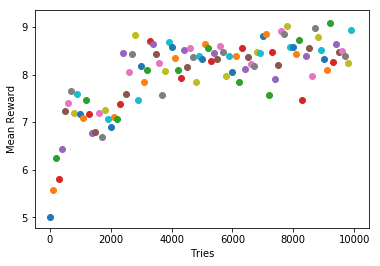

In [26]:
train(env)
